In [1]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images
5) de-extinct all the images
6) create apertures as appropriate for all the knots
7) perform relevant analyses: e.g. taking ratio and then finding EDFs, summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys



3.8.13


C:\Users\arubi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(D, hdu_pix_torad, hdu_dat, lam, kern):
    #gaussian kernel
    if kern == 'gauss':
        #update: usually cannot find wavelength but these headers are well-labeled    
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

This code uses cross correlation
Background paper examples
https://articles.adsabs.harvard.edu/pdf/1992ApJ...392..145R or https://iopscience.iop.org/article/10.1086/517493/pdf

Example stack overflow references...
https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images (the best)
https://stackoverflow.com/questions/61114057/how-to-estimate-motion-with-ftt-and-cross-correlation (not bad)
https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images (good conceptual explanation)

In [3]:
path = '../scaling_for_motions/160_epoch*.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
print(im_names_n2071)

im_names_n2071 = [im_names_n2071[0], im_names_n2071[2]]
print(im_names_n2071)

['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']
['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch2_synth.fits']


In [4]:
hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    
    #needed because the second image in this list is negative...
    if count == 1:
        sign = -1
    else:
        sign = 1
    hdu_data_list.append(sign * hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

In [5]:
#our plotting function
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')


In [6]:
%matplotlib inline

# Reading in a region file + indexing for cutouts
Seems like doing it with cutout2d for once worked better than doing it by hand...so let's just go with it.

Will help to then overlay this on the difference image

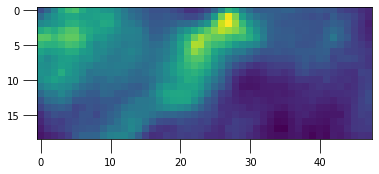

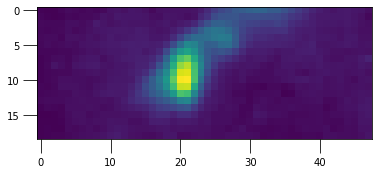

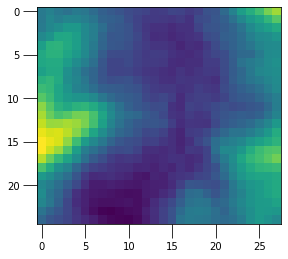

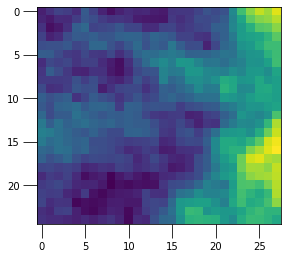

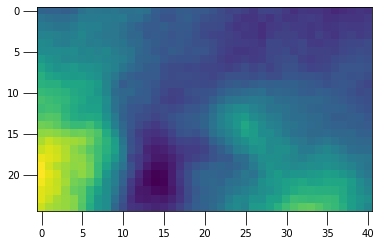

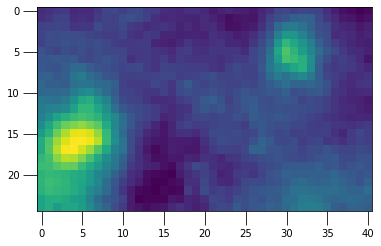

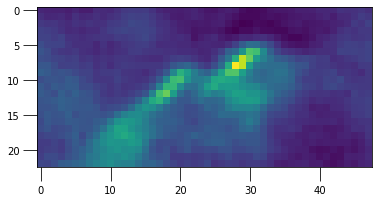

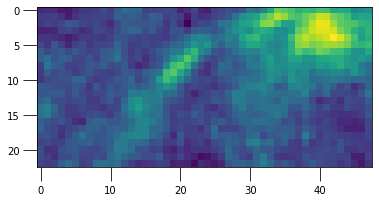

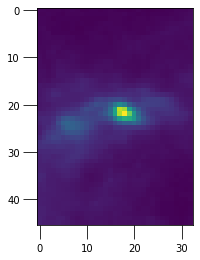

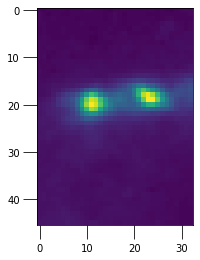

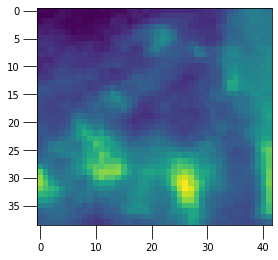

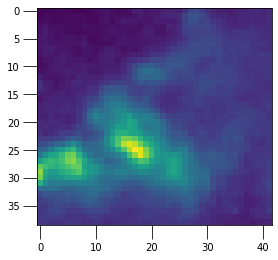

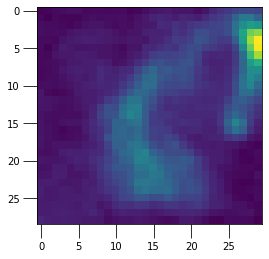

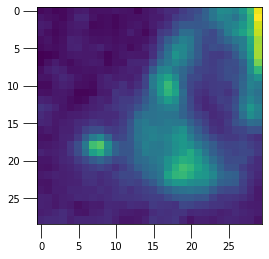

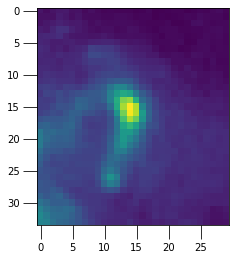

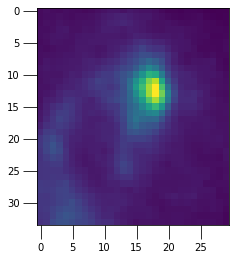

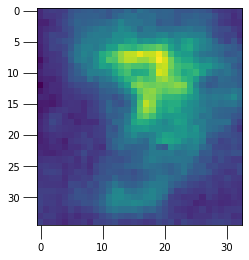

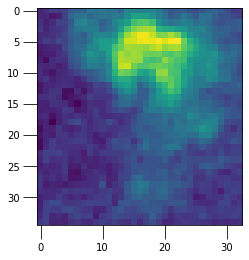

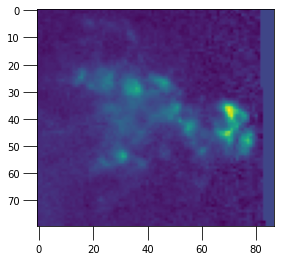

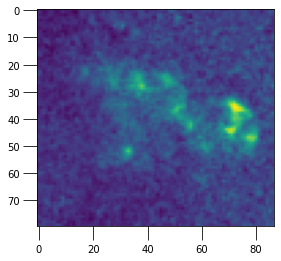

In [31]:
#trying this with cutout2d
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5
from photutils.aperture import RectangularAperture

#trying it by hand

#known pixel size
hst_pixsize = 0.12825 #arcsec

# f = open('moving_blobs.reg', 'r')
# f = open('moving_blobs_brightest_rotated_v2.reg', 'r')
f = open('361c_extraknots.reg')
file_output = []

#looping through file 
for line in f:
    file_output.append(line)
f.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file_output = [i[4:-2] for i in file_output[3:]]

#next step is for one image, loop through all regions and make a cutout list
radec_box = []
ra_pix_list = []
dec_pix_list = []
width_list = []
height_list = []
rotation_list = []


for reg_num, region_params in enumerate(file_output):
    split_params = region_params.split(',')
    ra = split_params[0].split(':')
    ra = ra[0]+'h' + ra[1]+'m' + ra[2]+'s'
    dec = split_params[1].split(':')
    dec = dec[0]+'d' + dec[1]+'m' + dec[2]+'s'
    width = np.abs(float(split_params[2][:-1]))
    height = np.abs(float(split_params[3][:-1]))
    rotation = float(split_params[4])

    position = SkyCoord(ra+' '+dec, frame=FK5)
    size = u.Quantity((height, width), u.arcsec)
    
    radec_box.append([ra, dec])
    ra_pix_list.append(skycoord_to_pixel(position, wcs=WCS(hdu_header_list[0]))[0])
    dec_pix_list.append(skycoord_to_pixel(position, wcs=WCS(hdu_header_list[0]))[1])
    width_list.append(width/hst_pixsize)
    height_list.append(height/hst_pixsize)
    rotation_list.append(rotation)

#looping through regions
epoch1_reg = []
epoch2_reg = []
count = 0
im_type = ['f160w_Epoch1_reg', 'f160w_Epoch2_reg']
for i in range(len(ra_pix_list)):
    try:
    
        #making apertures
        #         cutout = Cutout2D(im, position, size, wcs=WCS(header))
        aperture = RectangularAperture([ra_pix_list[count], dec_pix_list[count]], width_list[i], height_list[i], theta=rotation_list[i])
        aper_mask = aperture.to_mask()

        #retrieving data
        aper_cutout = aper_mask.cutout(hdu_data_list[0])
        epoch1_reg.append(aper_cutout.data)
                #plot
        #         plt.imshow(cutout.data, vmin=-5.12619e-18, vmax=3e-17)
        plt.imshow(aper_cutout.data, vmin=np.min(aper_cutout.data), vmax=np.max(aper_cutout.data))
        plt.show()
        
        aper_cutout = aper_mask.cutout(hdu_data_list[1])
        epoch2_reg.append(aper_cutout.data)
        #plot
        #         plt.imshow(cutout.data, vmin=-5.12619e-18, vmax=3e-17)
        plt.imshow(aper_cutout.data, vmin=np.min(aper_cutout.data), vmax=np.max(aper_cutout.data))
        plt.show()

        #         plt.savefig(im_type[count]+str(reg_num)+'.png')
    except Exception as e:
        print(e, i)
                
    count += 1

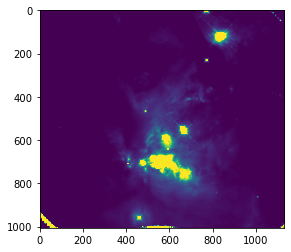

In [8]:
plt.imshow(hdu_data_list[0], vmin=1e-18, vmax=1e-16)

# plt.scatter(ra_pix_list[2], dec_pix_list[2], color='red')

# Most Basic Cross Correlations
Here we should just test one really really nice and really really bad test case to see which of these we like best

In [9]:
#taken from https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images
#alternatively, https://pyquestions.com/how-to-detect-a-shift-between-images

import numpy as np
import scipy.signal

def cross_image(im1, im2):
   # the type cast into 'float' is to avoid overflows
   # get rid of the averages, otherwise the results are not good
    im1 -= np.mean(im1)
    im2 -= np.mean(im2)

   # calculate the correlation image; note the flipping of onw of the images
    return scipy.signal.convolve2d(im1, im2[::-1,::-1])

[9, 23]


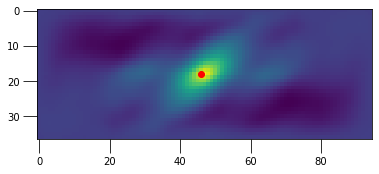

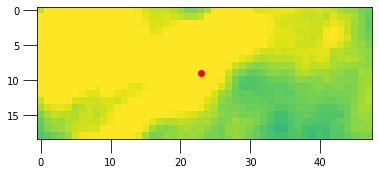

[9, 23]


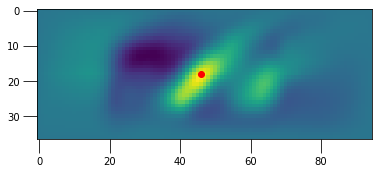

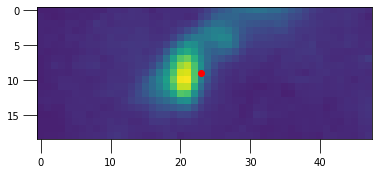

0.0 0.0 0.0


In [33]:
epoch1_example = epoch1_reg[0]
epoch2_example = epoch2_reg[0]

#cross-correlate image with itself to get the brightest spot originally
corr_img = cross_image(epoch1_example, epoch1_example)
self_brightest = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img), corr_img.shape)]
print(self_brightest)

plt.imshow(corr_img)
plt.scatter(2*self_brightest[1], 2*self_brightest[0], color='red')
plt.show()

plt.imshow(epoch1_example, vmin=-5.12619e-18, vmax=3e-17)
plt.scatter(self_brightest[1], self_brightest[0], color='red')
plt.show()

#Then do the cross-corr again but between the two images to find where the bright spot traveled to...
corr_img = cross_image(epoch1_example, epoch2_example)
moved_brightest = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img), corr_img.shape)]
print(moved_brightest)

plt.scatter(2*moved_brightest[1], 2*moved_brightest[0], color='red')
plt.imshow(corr_img)
plt.show()

plt.imshow(epoch2_example, vmin=5.12619e-18, vmax=3e-16)
plt.scatter(moved_brightest[1], moved_brightest[0], color='red')
plt.show()

n2071_dist = 1.234e16  #400 pc to km
pix_size = 0.12825
time = 3.156e8 #10 yrs to secs
horiz_speed = ((self_brightest[0] - moved_brightest[0]) *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed
vert_speed = ((self_brightest[1] - moved_brightest[1]) *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed

print(horiz_speed, vert_speed, np.sqrt(horiz_speed**2.+vert_speed**2.))

[9, 23]


ValueError: box_size must have integer values

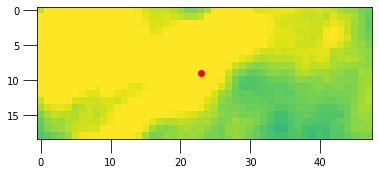

In [34]:
#attempting centroids...

corr_img = cross_image(epoch1_example, epoch1_example)
# plt.imshow(corr_img)
plt.imshow(epoch1_example, vmin=-5.12619e-18, vmax=3e-17)

self_brightest = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img), corr_img.shape)]
print(self_brightest)
plt.scatter(self_brightest[1], self_brightest[0], color='red')

from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg
from photutils.centroids import centroid_sources
x, y = centroid_sources(corr_img, self_brightest[1], self_brightest[0], 
                        box_size=[int(corr_img.shape[1]/2.)*2., corr_img.shape[0]], centroid_func=centroid_quadratic)
print(y/2,x/2)
plt.scatter(x/2, y/2, color='violet')
plt.show()


#Then do the cross-corr again but between the two images to find where the bright spot traveled to...
corr_img = cross_image(epoch1_example, epoch2_example)
# plt.imshow(corr_img)
plt.imshow(epoch2_example, vmin=-5.12619e-18, vmax=3e-17)
moved_brightest = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img), corr_img.shape)]
print(moved_brightest)
plt.scatter(moved_brightest[1], moved_brightest[0], color='red')
x, y = centroid_sources(corr_img, moved_brightest[1], moved_brightest[0], 
                        box_size=[int(corr_img.shape[1]/2.)*2., corr_img.shape[0]], centroid_func=centroid_quadratic)
print(y/2,x/2)
plt.scatter(x/2, y/2, color='violet')
plt.show()

# Cross-Corr + least squares fitting overlaps and displacements

Detected pixel offset (row, col): [ 1. -3.]


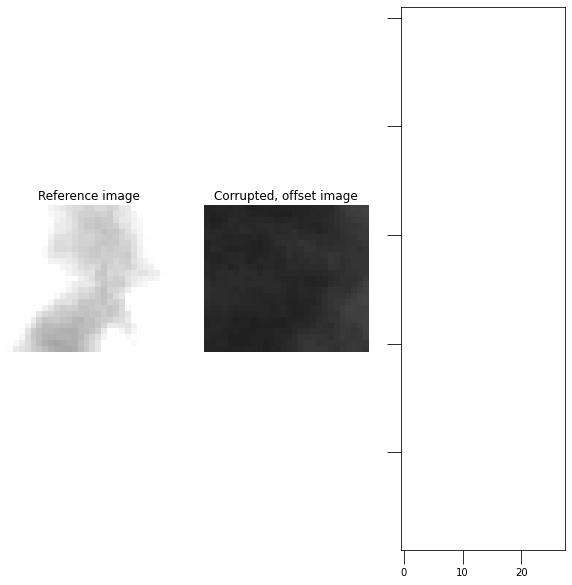

In [35]:
#let's try it again...
'''
Pseudocoding algorithms

Let us try to take the epoch 1 image cutout of interest. We'd need an initial guess for epoch 1 (already in hand)

Then we try to overlay it in an area of interest on the other image with the following parameters:
-box position
-box height and width
-box rotation
Or we could do something using ellipses, same idea. Now we apply it to some data, apply the cutout guess onto epoch 2

Most important is the comparison tool. There are many options to minimize. We can do:
1) Cross-correlation ~ 0 (estimates offsets)
2) sum of the grad ~ 0 (normalized, upon overlap a uniform or flat field should have 0 grad)
3) sum of residuals or diffs ~ 0 (unweighted error)
4) chi^2 ~ 0 (a weighted error)

After convergence, the output is the matching feature in the other image. Then...
just compute the shift from box 1 to box 2, and we get our resulting speed

Pros: Very precise
Cons: Does not account for brightness or structural changes

Options successful:
https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation
https://image-registration.readthedocs.io/en/latest/index.html and https://image-registration.readthedocs.io/en/latest/api/image_registration.chi2_shifts.chi2_shift.html#image_registration.chi2_shifts.chi2_shift

Alternatives:
https://github.com/cgohlke/imreg/
https://github.com/matejak/imreg_dft
https://suite2p.readthedocs.io/en/latest/registration.html
https://examples.itk.org/src/registration/common/globalregistrationoftwoimages/documentation

Options that have been tried and failed:
template_matching
my own max(cross correlation vs. autocorr) by hand
skimage match_template
'''
from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi

epoch1_example = epoch1_reg[1]
epoch2_example = epoch2_reg[1]

image= np.nan_to_num(epoch1_example)
offset_image = np.nan_to_num(epoch2_example)
# mask = offset_image[400:430, 660:710] > 0 #np.nan_to_num(epoch1_reg[2])


detected_shift = phase_cross_correlation(image, offset_image)
print(f'Detected pixel offset (row, col): {-detected_shift[0]}')

#plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True,
                                    figsize=(10,10))

ax1.imshow(image, cmap='gray', vmin=0, vmax=3e-17)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray', vmin=0, vmax=3e-16)
ax2.set_axis_off()
ax2.set_title('Corrupted, offset image')

# ax3.imshow(mask, cmap='gray')
# ax3.set_axis_off()
# ax3.set_title('Masked pixels')


plt.show()

In [36]:
from image_registration import chi2_shift
from image_registration.fft_tools import shift
xoff, yoff, exoff, eyoff = chi2_shift(image, offset_image,return_error=True, upsample_factor='auto')
print(xoff, yoff)

-3.552734375 -23.259765625


# Looping through regions

  Knot Dec (dd:mm:ss) Knot RA (hh:mm:ss) Knot Shift in X (pix)  \
0       +0d21m55.502s      5h47m04.7668s                   0.0   
1       +0d22m00.566s      5h47m04.7722s              0.468829   
2       +0d22m05.901s      5h47m04.9314s             -0.263486   
3       +0d22m16.181s      5h47m04.9103s                  -3.5   
4       +0d22m28.231s      5h47m05.3129s             -2.435844   
5       +0d22m31.654s      5h47m05.5060s             -1.852592   
6       +0d22m38.036s      5h47m05.8424s             -0.340353   
7       +0d22m39.891s      5h47m05.9254s             -1.621693   
8       +0d22m44.048s      5h47m06.6368s             -0.161289   
9       +0d22m53.254s      5h47m08.2490s              -0.81886   

  Knot Shift in Y (pix) Proper Motion (arcsec/yr) Speed (km/s)  
0                  -2.0                  0.023318    44.210189  
1               0.02329                  0.005473    10.376295  
2              0.184315                  0.003749     7.107979  
3            

C:\Users\arubi\AppData\Local\Temp\ipykernel_19172\2586574566.py:91: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_cc_speeds.to_latex(savepath, index=False)


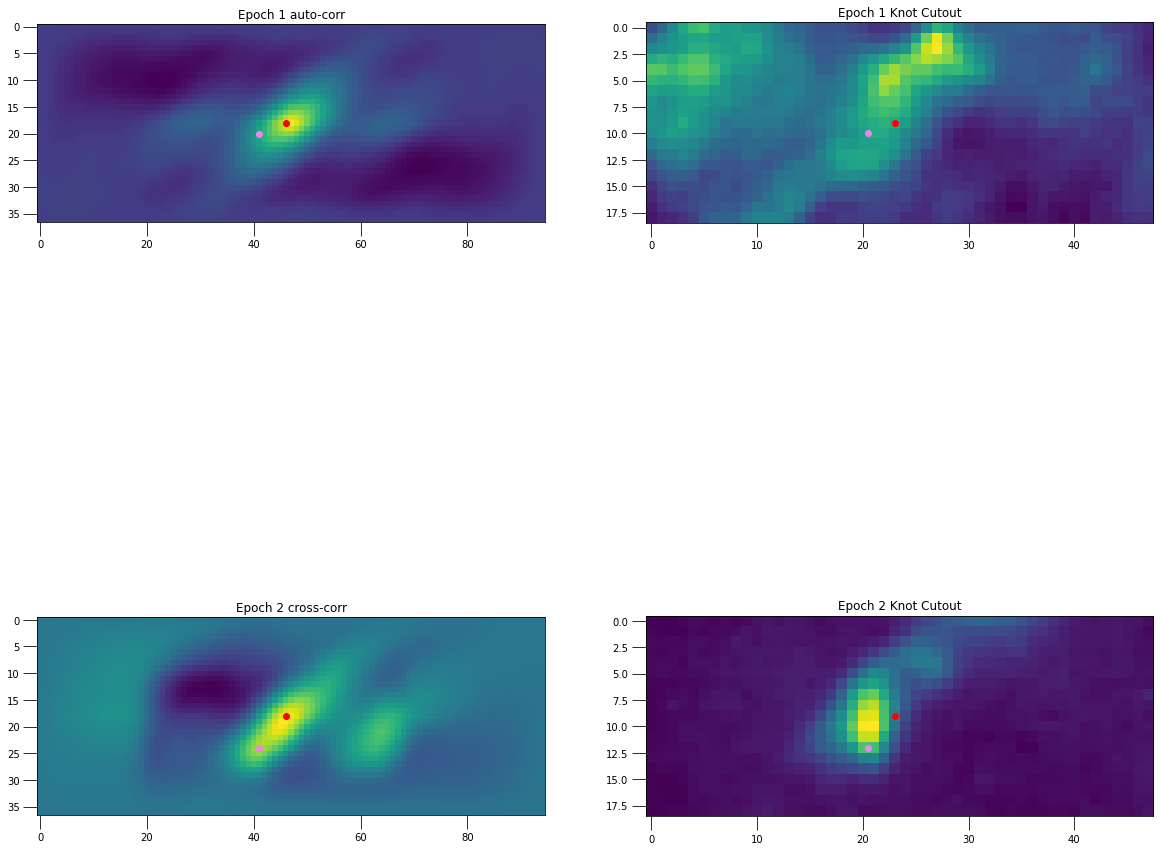

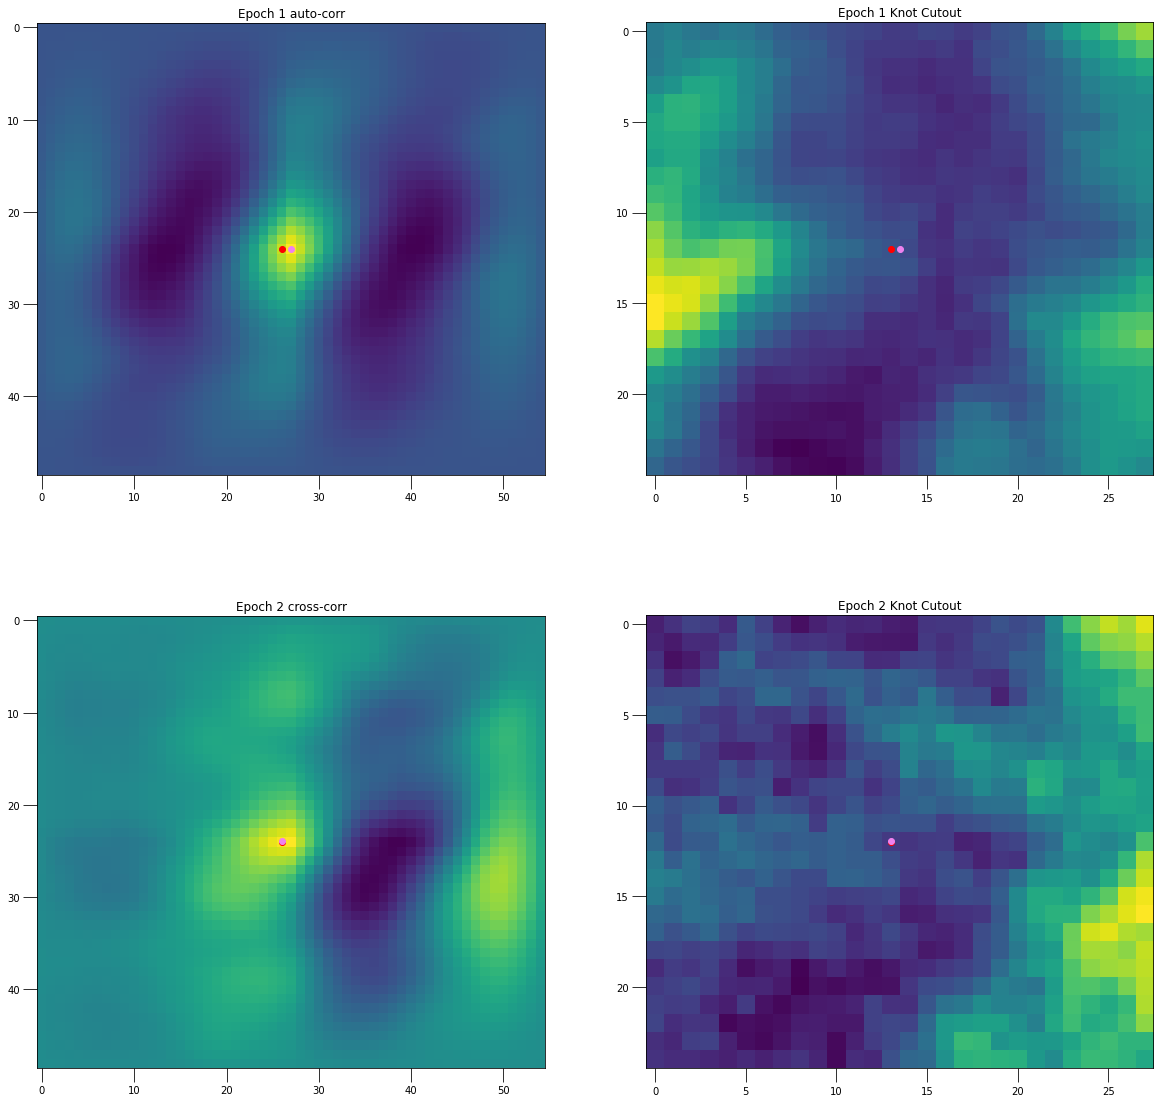

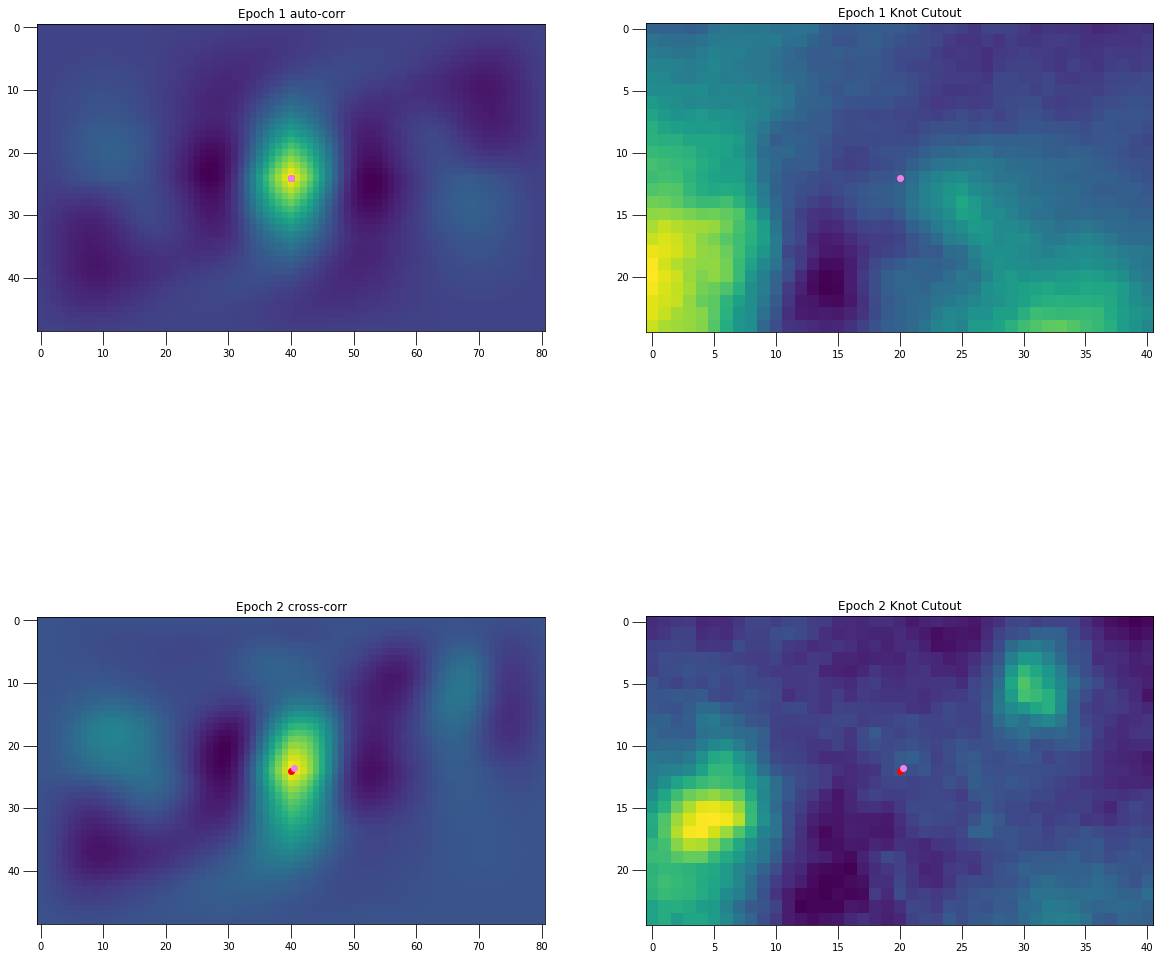

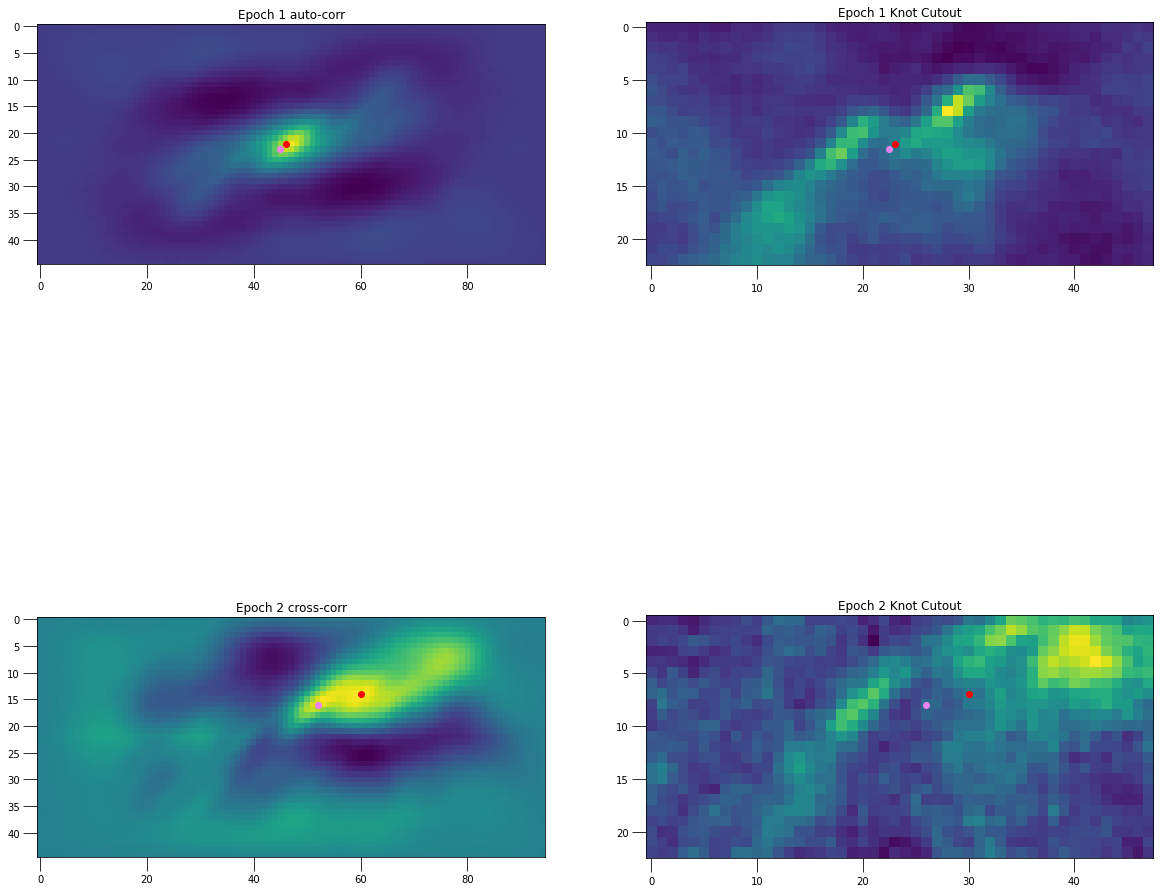

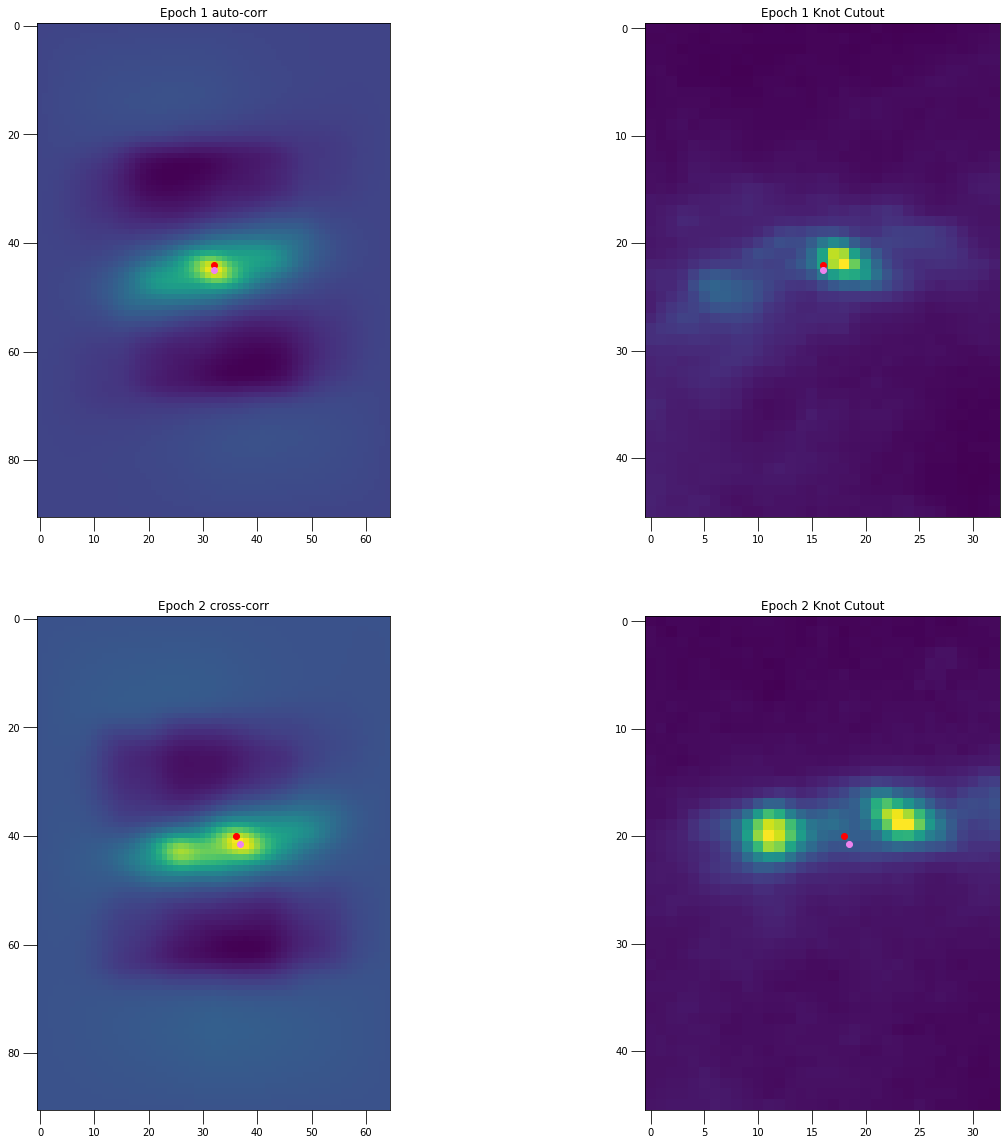

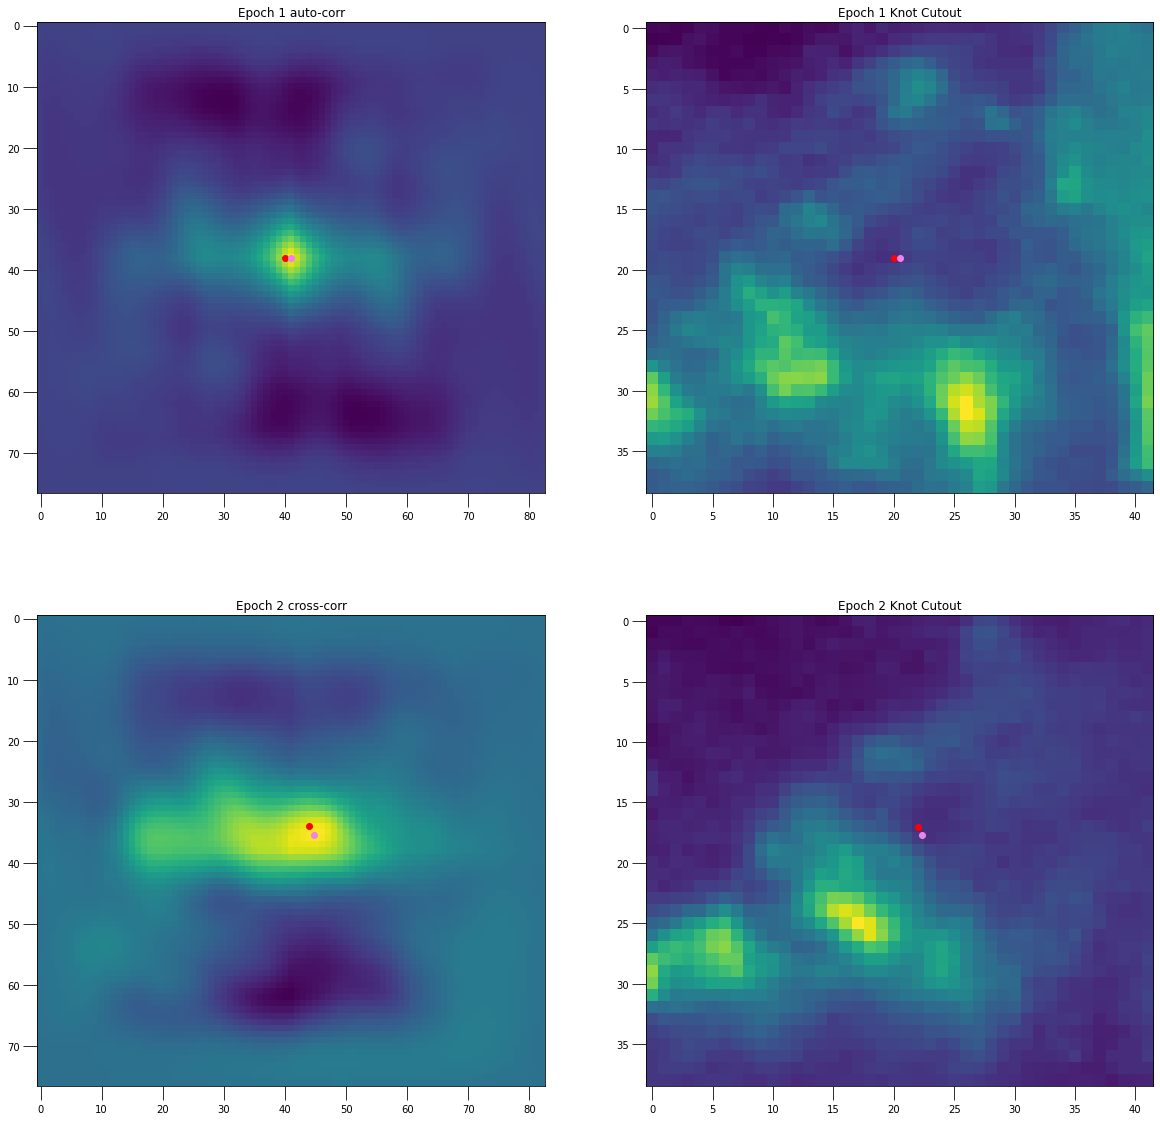

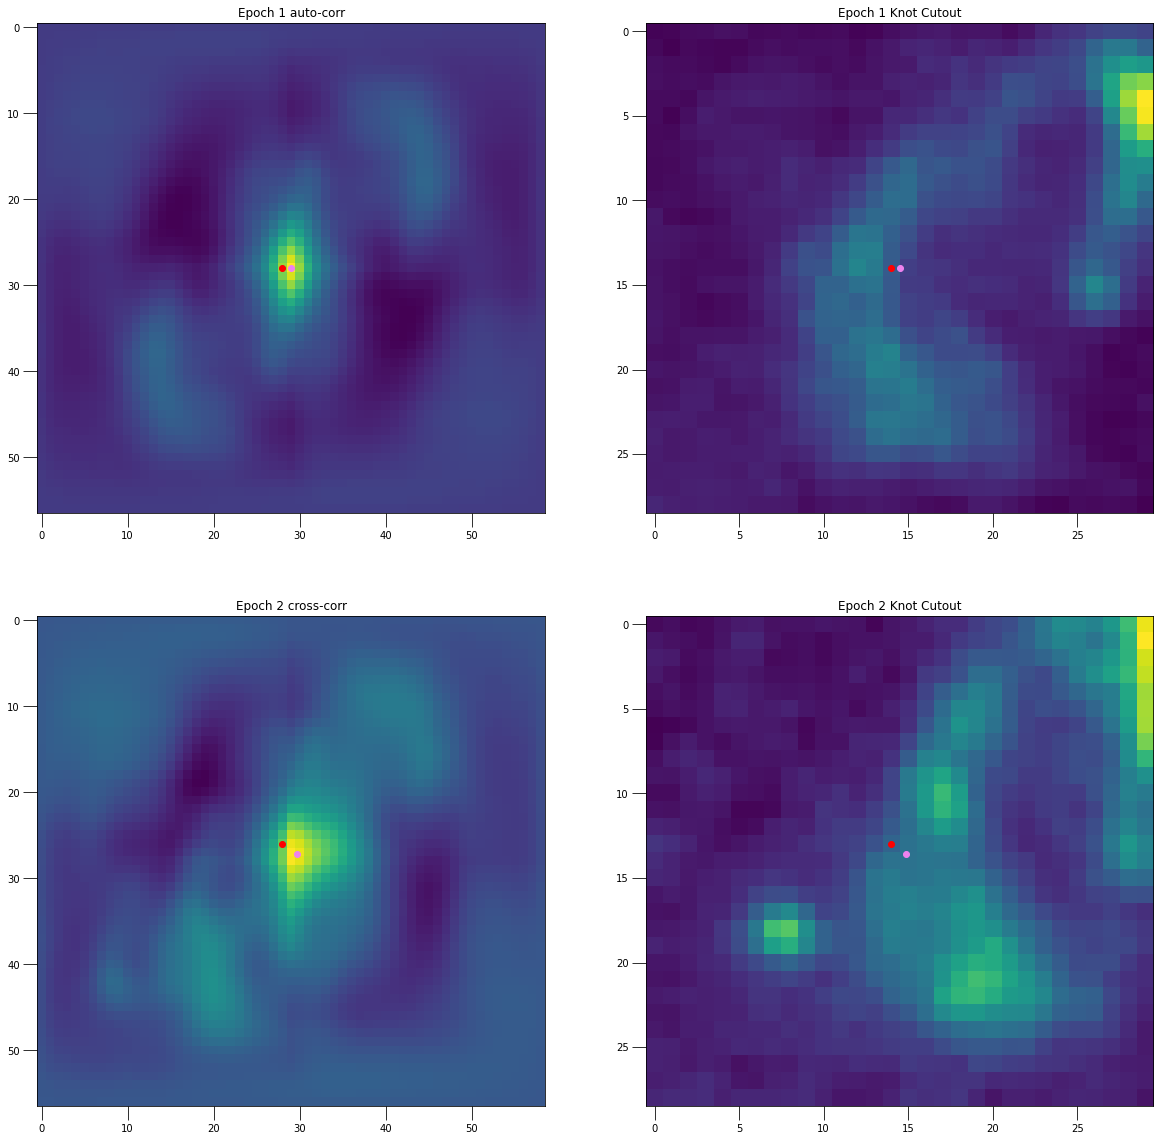

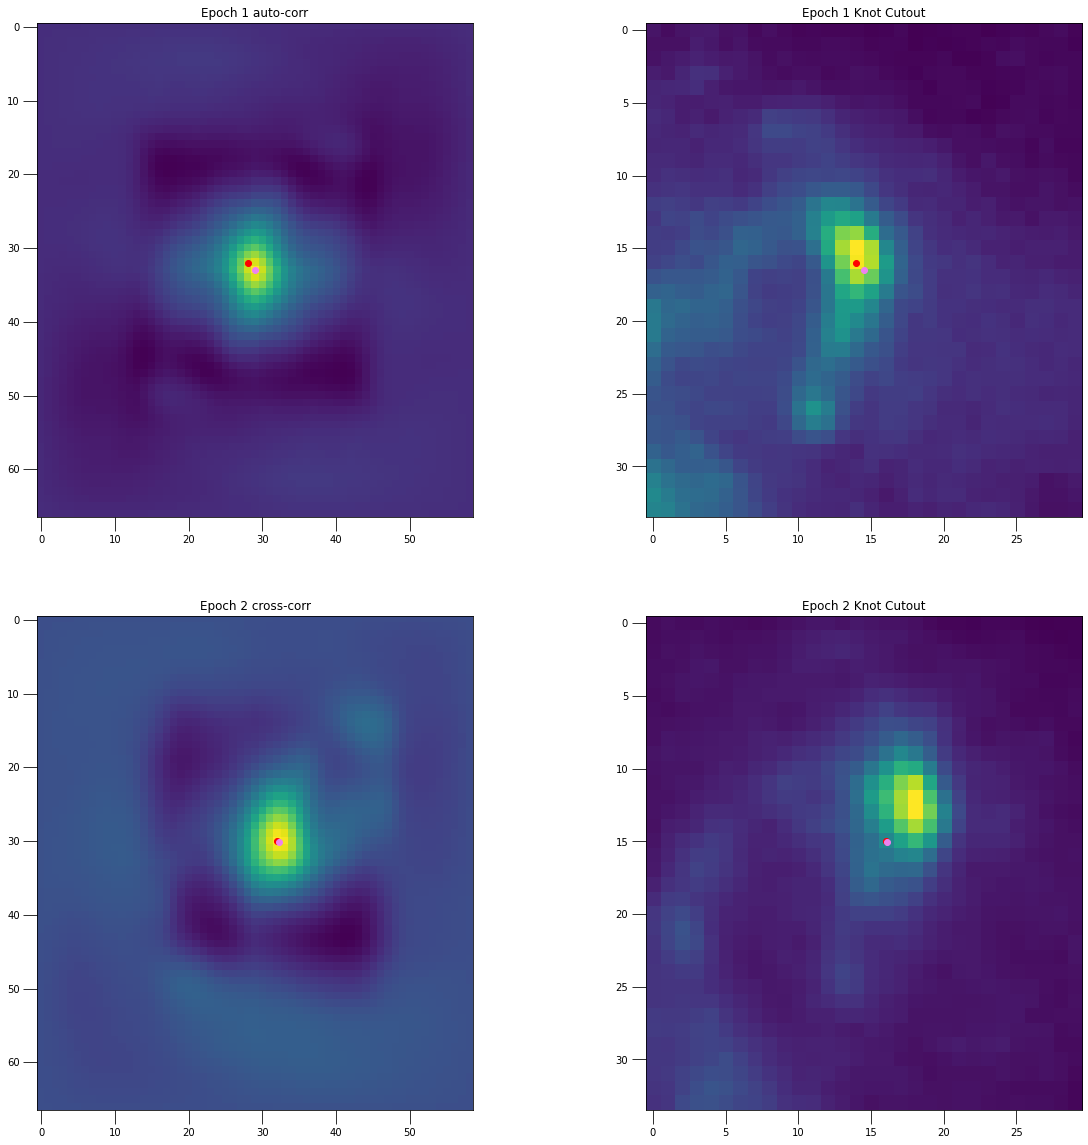

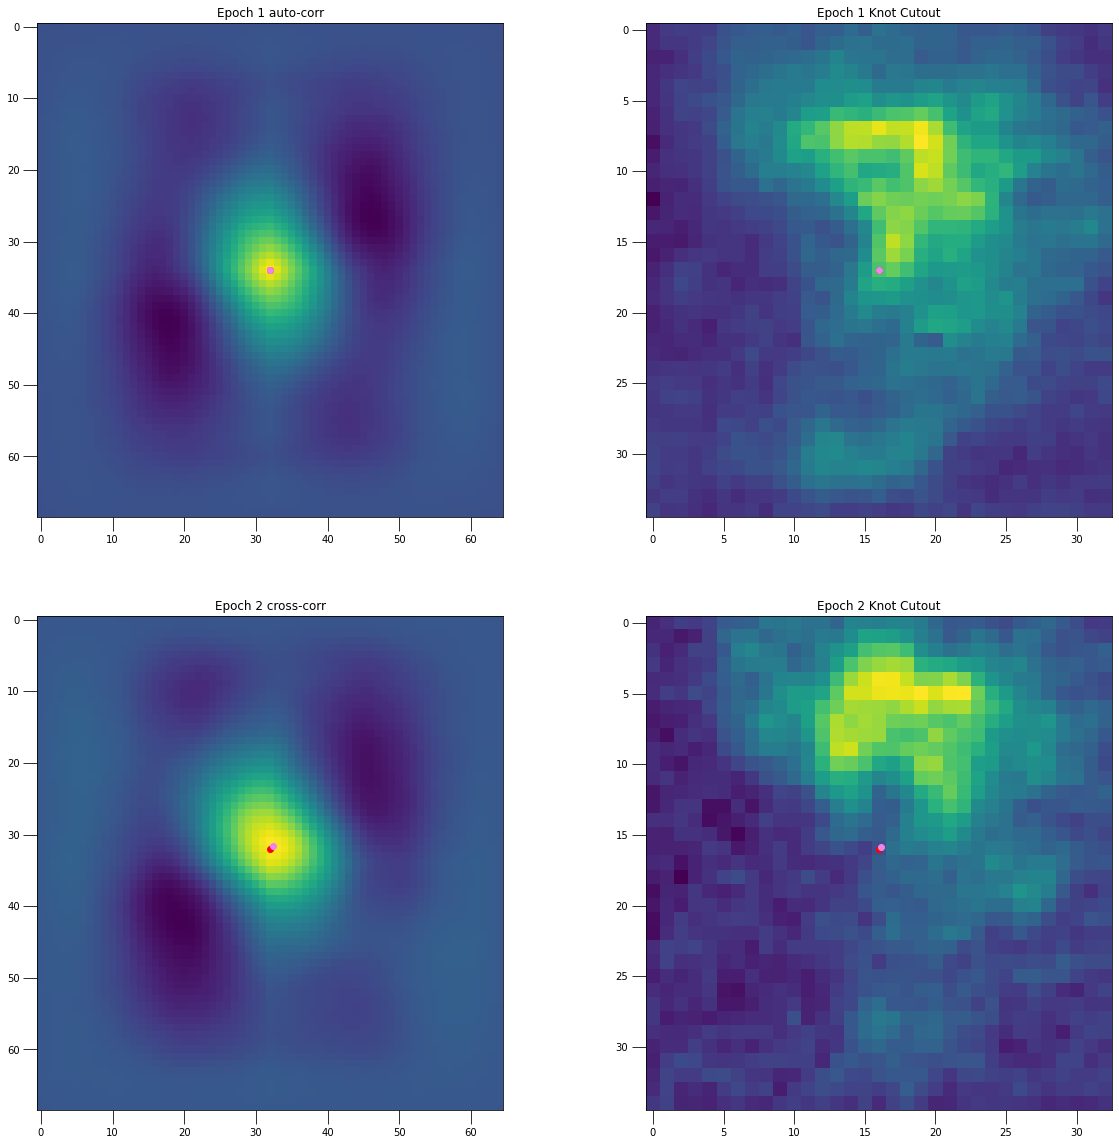

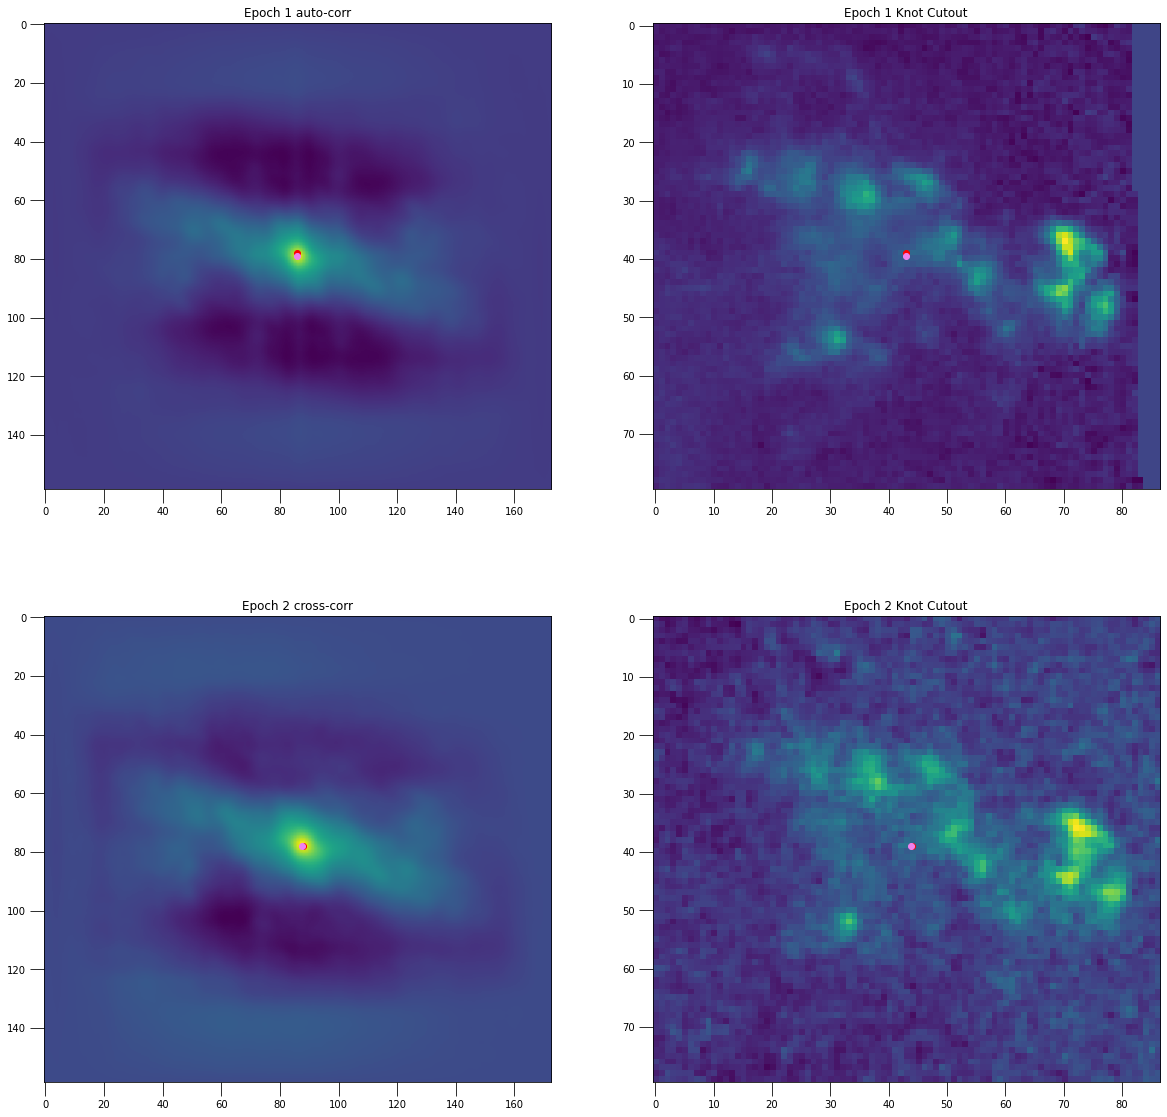

In [37]:
#taken from https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images
#alternatively, https://pyquestions.com/how-to-detect-a-shift-between-images

import numpy as np
import scipy.signal

def cross_image(im1, im2):
   # the type cast into 'float' is to avoid overflows
   # get rid of the averages, otherwise the results are not good
    im1 -= np.mean(im1)
    im2 -= np.mean(im2)

   # calculate the correlation image; note the flipping of onw of the images
    return scipy.signal.convolve(im1[::-1,::-1], im2)

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Knot Dec (dd:mm:ss)', 'Knot RA (hh:mm:ss)', 'Knot Shift in X (pix)', 'Knot Shift in Y (pix)', 'Proper Motion (arcsec/yr)', 'Speed (km/s)'] #columns
#creating dataframe and filling in the first two columns from the lists we just made
df_cc_speeds = pd.DataFrame(columns = column_names)
df_cc_speeds['Knot Dec (dd:mm:ss)'] = [i[1] for i in radec_box]
df_cc_speeds['Knot RA (hh:mm:ss)'] = [i[0] for i in radec_box]

self_brightest_list = [] #for use while plotting, marks origin of knots
for i in range(len(epoch1_reg)):    
    try:
        epoch1_box = epoch1_reg[i]
        epoch2_box = epoch2_reg[i]

        #cross-correlate image with itself to get the brightest spot originally
        corr_img1 = cross_image(epoch1_box, epoch1_box)
        self_brightest_guess = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img1), corr_img1.shape)]
    #     print(self_brightest)
        x, y = centroid_sources(corr_img1, self_brightest_guess[1], self_brightest_guess[0], 
                            box_size=[corr_img1.shape[1], corr_img1.shape[0]], centroid_func=centroid_quadratic)
        self_brightest = [x[0]/2, y[0]/2]
        self_brightest_list.append(self_brightest)

        #Then do the cross-corr again but between the two images to find where the bright spot traveled to...
        corr_img2 = cross_image(epoch1_box, epoch2_box)
        moved_brightest_guess = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img2), corr_img2.shape)]
    #     print(moved_brightest)
        x, y = centroid_sources(corr_img2, moved_brightest_guess[1], moved_brightest_guess[0], 
                            box_size=[corr_img2.shape[1], corr_img2.shape[0]], centroid_func=centroid_quadratic)
        moved_brightest = [x[0]/2, y[0]/2]
        
        #plotting
        fig, ax = plt.subplots(2, 2, figsize=(20, 20))
        ax[0,0].set_title('Epoch 1 auto-corr')
        ax[0,0].imshow(corr_img1, vmin=np.min(corr_img1), vmax=np.max(corr_img1)) #autocorr of epoch 1
        ax[0,0].scatter(2*self_brightest_guess[1], 2*self_brightest_guess[0], color='red') #max_cc*2
        ax[0,0].scatter(2*self_brightest[0], 2*self_brightest[1], color='violet') #centroid*2
        ax[0,1].set_title('Epoch 1 Knot Cutout')
        ax[0,1].imshow(epoch1_box, vmin=np.min(epoch1_box), vmax=np.max(epoch1_box)) #epoch 1 img
        ax[0,1].scatter(self_brightest_guess[1], self_brightest_guess[0], color='red') #max_cc
        ax[0,1].scatter(self_brightest[0], self_brightest[1], color='violet') #centroid
        ax[1,0].set_title('Epoch 2 cross-corr')
        ax[1,0].imshow(corr_img2, vmin=np.min(corr_img2), vmax=np.max(corr_img2)) #cross-corr of epochs 1 and 2
        ax[1,0].scatter(2*moved_brightest_guess[1], 2*moved_brightest_guess[0], color='red') #max_cc*2
        ax[1,0].scatter(2*moved_brightest[0], 2*moved_brightest[1], color='violet') #centroid*2
        ax[1,1].set_title('Epoch 2 Knot Cutout')
        ax[1,1].imshow(epoch2_box, vmin=np.min(epoch2_box), vmax=np.max(epoch2_box)) #epoch 2 img
        ax[1,1].scatter(moved_brightest_guess[1], moved_brightest_guess[0], color='red') #max_cc
        ax[1,1].scatter(moved_brightest[0], moved_brightest[1], color='violet') #centroid
        fig.savefig('check_centering/cc_knot'+str(i)+'_center.png')
        
        #computing table
        n2071_dist = 1.234e16  #400 pc to km
        pix_size = 0.12825
        time = 3.471e+8 #10 yrs to secs
        horiz_propmot = ((self_brightest[0] - moved_brightest[0]) *pix_size/11.) #divided by 11 yrs
        vert_propmot = ((self_brightest[1] - moved_brightest[1]) *pix_size/11.) #divided by 11 yrs
        horiz_speed = ((self_brightest[0] - moved_brightest[0]) *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed
        vert_speed = ((self_brightest[1] - moved_brightest[1]) *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed
    #     print(horiz_speed, vert_speed)

        df_cc_speeds['Knot Shift in X (pix)'].at[i] = (self_brightest[0] - moved_brightest[0])
        df_cc_speeds['Knot Shift in Y (pix)'].at[i] = (self_brightest[1] - moved_brightest[1])
        df_cc_speeds['Proper Motion (arcsec/yr)'].at[i] =  np.sqrt(horiz_propmot**2.+vert_propmot**2.)
        df_cc_speeds['Speed (km/s)'].at[i] = np.sqrt(horiz_speed**2.+vert_speed**2.)
    except:
        print(i)


#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
# savepath = 'proper_motions.xlsx'
# df_cc_speeds = df_cc_speeds.sort_values(by=['Knot Dec (dd:mm:ss)'], ascending=True)
print(df_cc_speeds)
savepath = 'proper_motions_table.tex'
df_cc_speeds.to_latex(savepath, index=False)
print('saved speeds!')

In [41]:
#see https://scikit-image.org/docs/stable/auto_examples/registration/plot_masked_register_translation.html

import numpy as np

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Knot Dec (dd:mm:ss)', 'Knot RA (hh:mm:ss)', 'Knot Shift in X (pix)', 'Knot Shift in Y (pix)', 'Proper Motion (arcsec/yr)', 'Speed (km/s)'] #columns
#creating dataframe and filling in the first two columns from the lists we just made
df_cc_speeds = pd.DataFrame(columns = column_names)
df_cc_speeds['Knot Dec (dd:mm:ss)'] = [i[1] for i in radec_box]
df_cc_speeds['Knot RA (hh:mm:ss)'] = [i[0] for i in radec_box]

self_brightest_list = [] #for use while plotting, marks origin of knots
for i in range(len(epoch1_reg)):    
    epoch1_box = np.nan_to_num(epoch1_reg[i])
    epoch2_box = np.nan_to_num(epoch2_reg[i])

    offset = phase_cross_correlation(epoch1_box, epoch2_box, overlap_ratio = 0.8)
    xshift = offset[0][0]
    yshift = offset[0][1]
    xshift, yshift, exoff, eyoff = chi2_shift(epoch1_box, epoch2_box)


    #computing table
    n2071_dist = 1.234e16  #400 pc to km
    pix_size = 0.12825
    time = 3.471e+8 #10 yrs to secs
    horiz_propmot = (xshift *pix_size/11.) #divided by 11 yrs
    vert_propmot = (yshift *pix_size/11.) #divided by 11 yrs
    horiz_speed = (xshift *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed
    vert_speed = (yshift *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed
#     print(horiz_speed, vert_speed)

    df_cc_speeds['Knot Shift in X (pix)'].at[i] = xshift
    df_cc_speeds['Knot Shift in Y (pix)'].at[i] = yshift
    df_cc_speeds['Proper Motion (arcsec/yr)'].at[i] =  np.sqrt(horiz_propmot**2.+vert_propmot**2.)
    df_cc_speeds['Speed (km/s)'].at[i] = np.sqrt(horiz_speed**2.+vert_speed**2.)


#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
# savepath = 'proper_motions.xlsx'
# df_cc_speeds = df_cc_speeds.sort_values(by=['Knot Dec (dd:mm:ss)'], ascending=True)
print(df_cc_speeds)
savepath = 'proper_motions_table.tex'
df_cc_speeds.to_latex(savepath, index=False)
print('saved speeds!')

  Knot Dec (dd:mm:ss) Knot RA (hh:mm:ss) Knot Shift in X (pix)  \
0       +0d21m55.502s      5h47m04.7668s             -0.857422   
1       +0d22m00.566s      5h47m04.7722s             -3.552734   
2       +0d22m05.901s      5h47m04.9314s              0.765625   
3       +0d22m16.181s      5h47m04.9103s             12.142578   
4       +0d22m28.231s      5h47m05.3129s            -27.486328   
5       +0d22m31.654s      5h47m05.5060s              3.740234   
6       +0d22m38.036s      5h47m05.8424s              0.236328   
7       +0d22m39.891s      5h47m05.9254s             33.373047   
8       +0d22m44.048s      5h47m06.6368s              1.136719   
9       +0d22m53.254s      5h47m08.2490s              1.832031   

  Knot Shift in Y (pix) Proper Motion (arcsec/yr) Speed (km/s)  
0            -18.185547                  0.212262   402.439799  
1            -23.259766                  0.274333   520.122411  
2             25.296875                  0.295074   559.445868  
3            

C:\Users\arubi\AppData\Local\Temp\ipykernel_19172\3194086811.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_cc_speeds.to_latex(savepath, index=False)


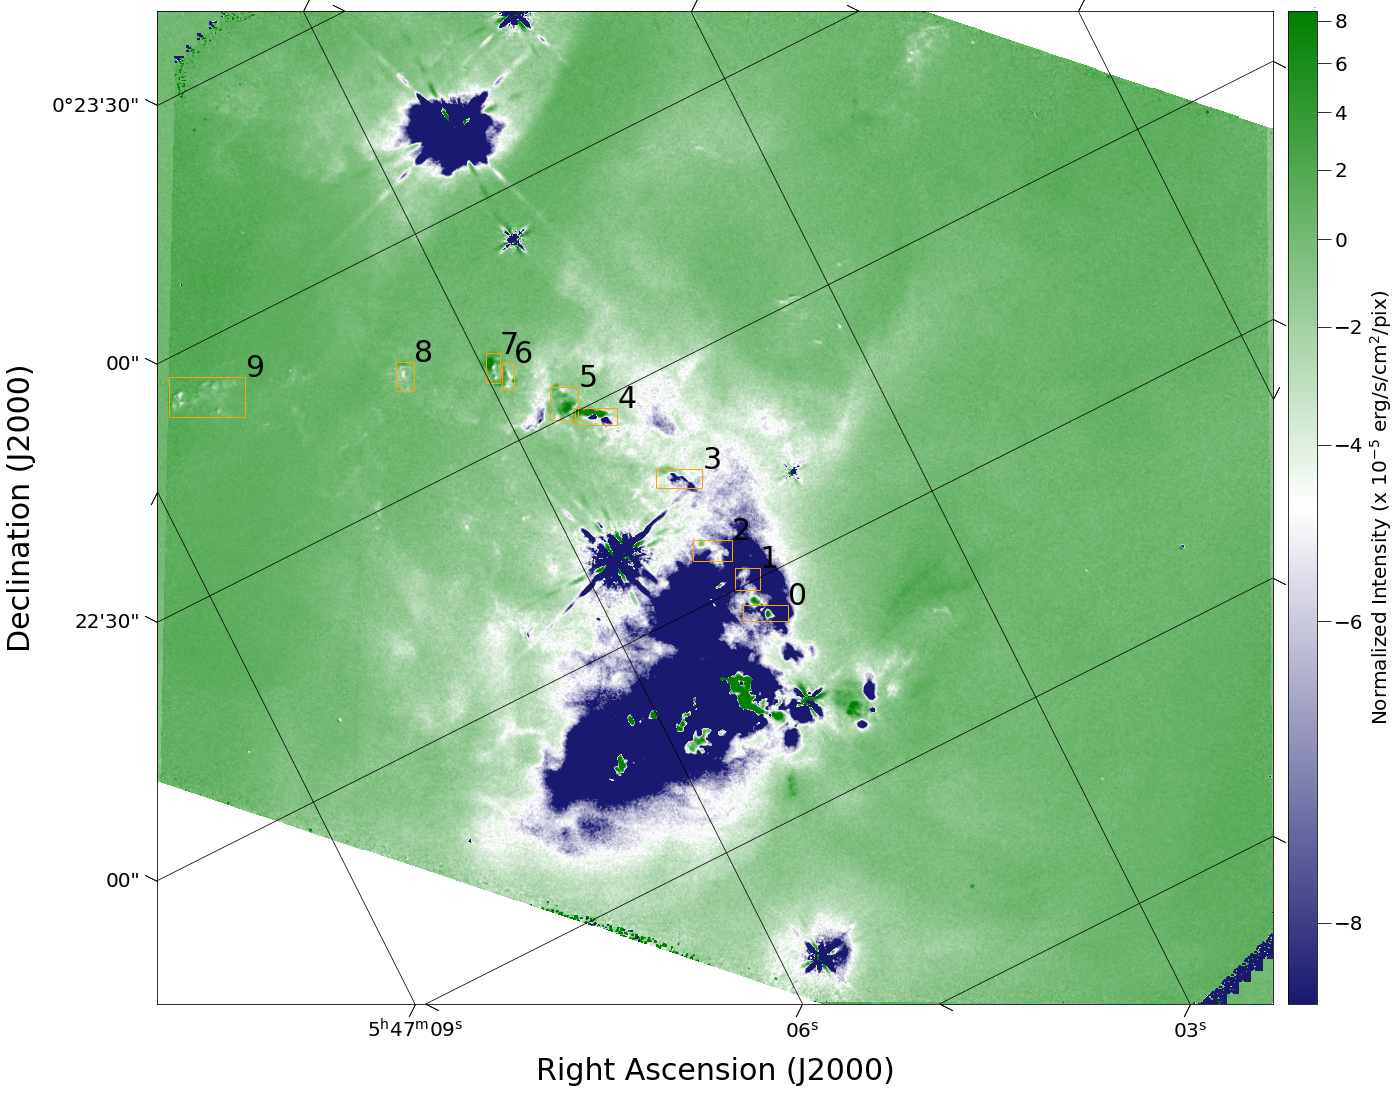

In [16]:
#overlaying on the difference image
diff_path = '../scaling_for_motions/f160_diff_epoch2_1.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
diff_hdu_list = fits.open(diff_path)
diff_data = diff_hdu_list[0].data
diff_header = diff_hdu_list[0].header

#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]
coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(diff_header)))
    
#begin plot
fig, ax = plt.subplots(figsize=(20, 20))
#projecting to correctly present data...
wcs = WCS(diff_header)
ax = plt.subplot(projection=wcs)


#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(diff_data)
ds9_min = -8.41819e-05
ds9_max = 8.47856e-05 
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)

import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","white","green"])
im = ax.imshow(diff_data , norm=norm, origin='lower', cmap=cmap)#'seismic')
# hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='orange', marker='+', s=mark_size) for c_pair,mark_size in zip(coord_pix_list, size_list)]

#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
for ind in range(len(ra_pix_list)):
    box_order = df_cc_speeds.index.values[ind]
    try:
        #boxes params
        x_pix = ra_pix_list[box_order]
        y_pix = dec_pix_list[box_order]
        width_pix = width_list[box_order]
        height_pix = height_list[box_order]

        #arrow params
        x_origin = x_pix#-width_pix/2.-self_brightest_list[box_order][1]
        y_origin = y_pix#-height_pix/2.-self_brightest_list[box_order][0]
        dx = df_cc_speeds['Knot Shift in X (pix)'].values[ind]
        dy = df_cc_speeds['Knot Shift in Y (pix)'].values[ind]
        
        #plotting
        rect = patches.Rectangle((x_pix-width_pix/2., y_pix-height_pix/2.), width_pix, height_pix, linewidth=1, edgecolor='orange', facecolor='none') # Create a Rectangle patch
        ax.add_patch(rect) # Add the patch to the Axes
        plt.annotate(str(ind), (x_pix-width_pix/2., y_pix-height_pix/2.), fontsize=30)
    except Exception as e:
        print(e)
        
#general formatting
ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.invert_yaxis() #done because it's nicer with declination increasing
ax.invert_xaxis() #done because it's nicer with declination increasing
    
#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Normalized~Intensity~(x~{10}^{-5}~erg/s/{cm}^{2}/pix)$', size=20)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]

plt.savefig('f160w_diffepoch_2_1_reg_labeled.png', dpi=300, bbox_inches="tight")

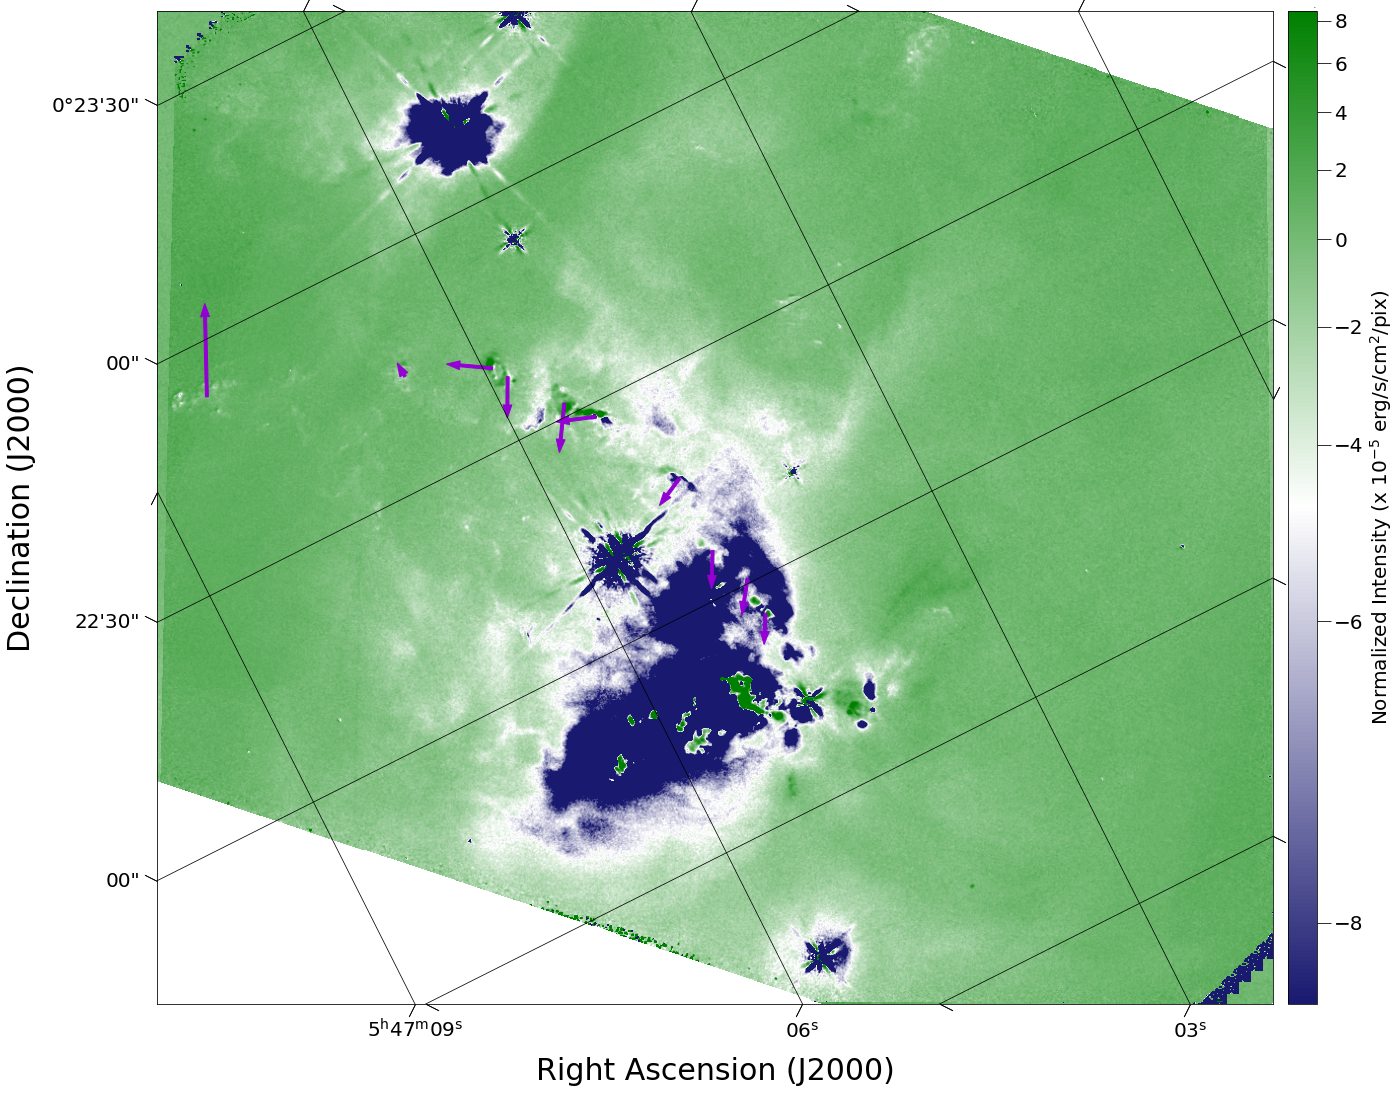

In [42]:
#overlaying on the difference image
diff_path = '../scaling_for_motions/f160_diff_epoch2_1.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
diff_hdu_list = fits.open(diff_path)
diff_data = diff_hdu_list[0].data
diff_header = diff_hdu_list[0].header

#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]
coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(diff_header)))
    
#begin plot
fig, ax = plt.subplots(figsize=(20, 20))
#projecting to correctly present data...
wcs = WCS(diff_header)
ax = plt.subplot(projection=wcs)


#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(diff_data)
ds9_min = -8.41819e-05
ds9_max = 8.47856e-05 
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)

import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","white","green"])
im = ax.imshow(diff_data , norm=norm, origin='lower', cmap=cmap)#'seismic')
# hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='orange', marker='+', s=mark_size) for c_pair,mark_size in zip(coord_pix_list, size_list)]

#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
for ind in range(len(ra_pix_list)):
    try:
        #boxes params
        x_pix = ra_pix_list[ind]
        y_pix = dec_pix_list[ind]
        width_pix = width_list[ind]
        height_pix = height_list[ind]
        theta_rad = rotation_list[ind] * np.pi/180.

        #arrow params
        x_origin = x_pix#+width_pix/2. #-self_brightest_list[ind][1]
        y_origin = y_pix#+height_pix/2. #-self_brightest_list[ind][0]
        dx = df_cc_speeds['Knot Shift in X (pix)'].values[ind]
        dy = df_cc_speeds['Knot Shift in Y (pix)'].values[ind]
        theta_skimage = np.arctan(dy/dx)
        
        #plotting
        ax.arrow(x_origin, y_origin, np.sqrt(dx**2.+dy**2.)*np.cos(theta_skimage), np.sqrt(dx**2.+dy**2.)*np.sin(theta_skimage), width=3., color='darkviolet')
    except Exception as e:
        print(e)
        
#general formatting
ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.invert_yaxis() #done because it's nicer with declination increasing
ax.invert_xaxis() #done because it's nicer with declination increasing
    
#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Normalized~Intensity~(x~{10}^{-5}~erg/s/{cm}^{2}/pix)$', size=20)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]

# plt.savefig('f160w_diffepoch_2_1_arrow_labeled.png', dpi=300, bbox_inches="tight")

0
1
2
3
4
5
6


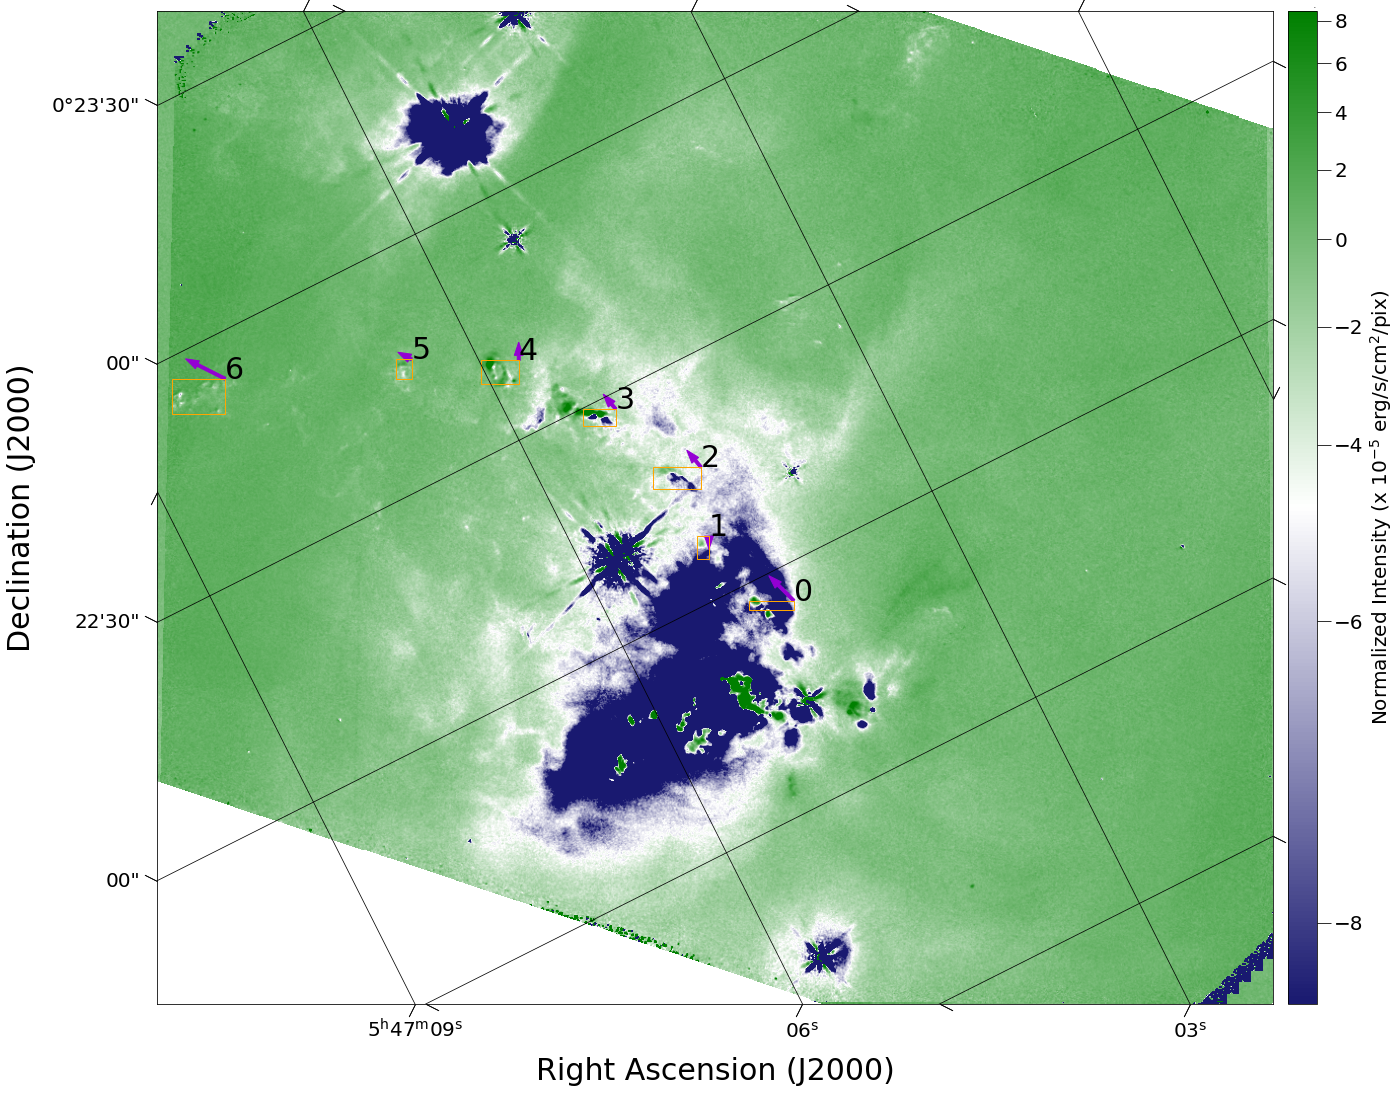

In [138]:
#overlaying on the difference image
diff_path = '../scaling_for_motions/f160_diff_epoch2_1.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
diff_hdu_list = fits.open(diff_path)
diff_data = diff_hdu_list[0].data
diff_header = diff_hdu_list[0].header

#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]
coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(diff_header)))
    
#begin plot
fig, ax = plt.subplots(figsize=(20, 20))
#projecting to correctly present data...
wcs = WCS(diff_header)
ax = plt.subplot(projection=wcs)


#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(diff_data)
ds9_min = -8.41819e-05
ds9_max = 8.47856e-05 
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)

import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","white","green"])
im = ax.imshow(diff_data , norm=norm, origin='lower', cmap=cmap)#'seismic')
# hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='orange', marker='+', s=mark_size) for c_pair,mark_size in zip(coord_pix_list, size_list)]

#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
for ind in range(len(ra_pix_list)):
    try:
        print(ind)

        #boxes params
        x_pix = ra_pix_list[ind]
        y_pix = dec_pix_list[ind]
        width_pix = width_list[ind]
        height_pix = height_list[ind]
        theta_rad = rotation_list[ind] * np.pi/180.

        #arrow params
        x_origin = x_pix-width_pix/2.#+self_brightest_list[ind][0]
        y_origin = y_pix-height_pix/2.#self_brightest_list[ind][1]
        dx = df_cc_speeds['Knot Shift in X (pix)'].values[ind]
        dy = df_cc_speeds['Knot Shift in Y (pix)'].values[ind]
        
        #plotting
        ax.arrow(x_origin, y_origin, -np.sqrt(dx**2.+dy**2.)*np.cos(theta_rad), -np.sqrt(dx**2.+dy**2.)*np.sin(theta_rad), width=3., color='darkviolet')
        rect = patches.Rectangle((x_pix-width_pix/2., y_pix-height_pix/2.), width_pix, height_pix, linewidth=1, edgecolor='orange', facecolor='none') # Create a Rectangle patch
        ax.add_patch(rect) # Add the patch to the Axes
        ax.annotate(str(ind), (x_pix-width_pix/2., y_pix-height_pix/2.), fontsize=30)
    except Exception as e:
        print(e)
        
#general formatting
ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.invert_yaxis() #done because it's nicer with declination increasing
ax.invert_xaxis() #done because it's nicer with declination increasing
    
#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Normalized~Intensity~(x~{10}^{-5}~erg/s/{cm}^{2}/pix)$', size=20)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]

plt.savefig('f160w_diffepoch_2_1_box_arrow_labeled.png', dpi=300, bbox_inches="tight")

# Finally, cross-check with good papers on the topic
Reipurth 92: https://articles.adsabs.harvard.edu/pdf/1992ApJ...392..145R

(especially this one -->) Garcia-Diaz 2015: https://iopscience.iop.org/article/10.1088/0004-637X/798/2/129/pdf